# Import dependencies

In [2]:
from InstructorEmbedding import INSTRUCTOR
import pandas as pd
from pathlib  import Path
src_dir = Path.cwd().parent
import sys
sys.path.append(str(src_dir))

In [4]:
from InstructorEmbedding import INSTRUCTOR
model = INSTRUCTOR('hkunlp/instructor-large')
sentence = "3D ActionSLAM: wearable person tracking in multi-floor environments"
instruction = "Represent the Science title:"
embeddings = model.encode([[instruction,sentence]])
print(embeddings)

load INSTRUCTOR_Transformer


ModuleNotFoundError: No module named 'fused_layer_norm_cuda'

# Read definitions

In [7]:
all_1_definitions = pd.read_json(src_dir / "data/tasks/all_1_definitions.json").drop_duplicates(['definition'])
all_0_definitions = pd.read_json(src_dir/ "data/tasks/all_0_definitions.json").drop_duplicates(['definition'])
all_definitions= pd.concat([all_0_definitions, all_1_definitions], axis=0).reset_index(drop=True)

# Clean definitions

### Remove definitions that contain entities such as ORG, Product, Person, etc.

In [ ]:
from src.language_model.spacy_loader import  SpacyLoader

In [ ]:
nlp = SpacyLoader(lm="en_core_web_trf",
                  entity_matcher=str(src_dir/'artifacts/matcher_model'),
                 load_matcher=True)


In [37]:
# extract NER entities
sents, spans, group_docs, aliases_docs = nlp.predictor(all_definitions['definition'])

In [39]:
# creare mask for the sentence definition that containes no entitiy tags
_no_tags = list(map(lambda x : True if len(x)==0  else False, spans))
print("Number of definitions with tags is `{}` out of {} definition".format(len(all_definitions) - sum(_no_tags), len(all_definitions)))

Number of definitions with tags is `1033` out of 4697 definition


In [30]:
# drop all definitions with tags
all_definitions = all_definitions[_no_tags].reset_index(drop=True)

['Supplier companies may be referred to as those that account for a significant portion of total revenues.',
 'Customer companies may be referred to as those that account for a significant portion of total accounts receivable.',
 "Customer companies may be referred to as entities that generate a substantial portion of another company's revenue.",
 'Supplier companies may be referred to as entities responsible for manufacturing products for a specific customer.',
 'Customer companies may be referred to as entities relying on suppliers for timely and adequate funding to ensure product manufacturing.']

### `TODO` Drop near duplicates defintions

In [42]:
from src.matcher.core import SimCSE_Matcher



In [43]:
SimCSE_Matcher?

Init signature:
SimCSE_Matcher(
    model_name_or_path: str,
    device: str = None,
    num_cells: int = 100,
    num_cells_in_search: int = 10,
    pooler=None,
)
Docstring:      A class for embedding entit names, calculating similarities, and retriving entities by SimCSE.
File:           /notebooks/inferess-relation-extraction/src/matcher/core.py
Type:           type
Subclasses:     


In [44]:

#Using Sentence encoder and Faiss to group near duplicates
matcher = SimCSE_Matcher(model_name_or_path="princeton-nlp/sup-simcse-roberta-large",
                        device="cuda")

# Clustering embeddings with kMeans

In [9]:
import sklearn.cluster
# Create definitions queries
definitions  = [ ['Represent the finance sentence for clustering: ',x] for x in all_definitions['definition'].tolist()]


In [10]:
embeddings = model.encode(definitions)


In [13]:
embeddings.shape

(4697, 768)

In [14]:
clustering_model = sklearn.cluster.MiniBatchKMeans(n_clusters=50)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
all_definitions['cluster_number'] = cluster_assignment

In [19]:
pd.set_option("dto_excel.max_colwidth", None)
for cluster in set( all_definitions['cluster_number'].unique()): 
    cluster_data = all_definitions.query(f"cluster_number == {cluster}")
    print("="*20, "\n", f"Cluster = {cluster}\n", "="*20, "\n")
    print("#datapoint: {}".format(cluster_data.shape[0]))
    print("\n---------------------\n".join(cluster_data.sample(len(cluster_data) if len(cluster_data) < 10 else 10)['definition']))

 Cluster = 0

#datapoint: 11
There is no relation between companies when they are involved in a merger and acquisition transaction.
---------------------
There is no relation between companies when one undergoes a reverse merger with another unrelated company.
---------------------
There is no relation between companies when one company cashes out stock options and units during a merger.
---------------------
There is no relation between companies when they merge with and become part of a different organization.
---------------------
There is no relation between companies when the completion of the merger is not influenced by stock price fluctuations.
---------------------
There is no relation between companies when a merger occurs between other companies in the industry.
---------------------
There is no relation between companies when stock options and units are cashed out during a merger.
---------------------
There is no relation between companies when a restatement is necessary du

In [22]:
all_definitions.to_excel("../data/tasks/all_0_1_definitions_clustered.xlsx")

  0%|          | 0/18 [00:00<?, ?it/s]

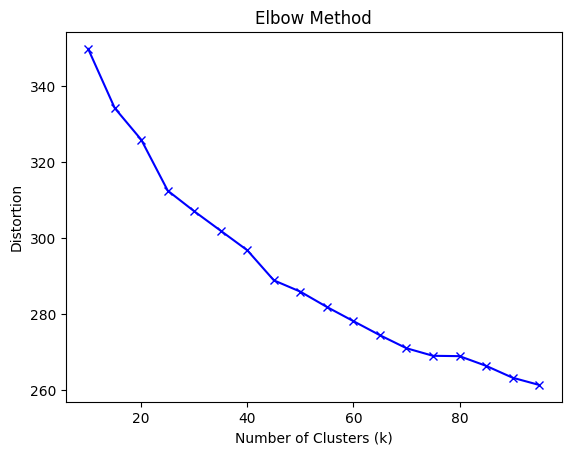

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm.auto import tqdm


# Perform k-means clustering for different values of k
distortions = []
K = range(10, 100, 5)
for k in tqdm(K):
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()